### Key terms and discussion
* Descriptive Statistics
* Inferential Statistics
* Probability Distributions
* Sampling Distributions
* Central Limit Theorem
* Confidence Intervel
* Hypothesis Testing

###What is an AB test?

Imagine you’re in charge of a website to optimise sales. You have the current version of the website, but aren’t happy with it. The “Buy now” button is not obvious to the user, it’s hidden away, so you want to try making it bigger and brighter, maybe that will increase conversion. But you also care about statistical rigour (an odd combination to be sure). So you set up your website so that half the people are directed to the old website, and half to one where you’ve made your change. You have data from both, and want to know, with confidence, “Does the change I made increase conversion?”.
![alt text](https://cosmiccoding.com.au/static/img/tutorials/abtests/2020-01-12-ABTests_1_0.jpg)

This is an A/B test. Often this is used interchangably with the term “split testing”, though in general A/B tests test small changes, and split testing might be when you present two entirely different websites to the user.

Why not just change the website and monitor it for a week? Good question - by having two sites active at once and randomly directing users to one or the other, you control for all other variables. If one week later puts you the week before Christmas, this will impact sales, and you might draw the wrong conclusion because of these confounding effects.

Why is it not an A/B/C test? Well, you can have as many perturbations running as you want, but got to keep the name simple. The more perturbations you try though, the smaller a number of samples you’ll have for each case, and the harder it will be to draw statistically significant conclusions.


In [ ]:
from scipy.stats import binom
from scipy.stats import norm
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
import numpy as np

Now, A/B tests can test anything you want, but common ones are click through/conversion, bounce rate, and how long you spend on the page. For this example, let us assume we want to optimise conversion, which in our case is clicking the “Add to cart” button above.

Establishing random groups is an essential component to an effective AB testing or multivariate testing strategy. Assigning test subjects, in this case, website visitors, to groups in a random fashion minimizes the potential for bias in the test.

Let us assume you have 1000 users, 550 were directed to site A, 450 to site B. In site A, 48 users converted. In site B, 56 users converted. Is this a statistically significant result?

In [ ]:
num_a, num_b = 550, 450
click_a, click_b = 48, 56
rate_a, rate_b = click_a / num_a, click_b / num_b

display(rate_a)
display(rate_b)

0.08727272727272728

0.12444444444444444

### What is a binomial distribution?


A binomial distribution can be thought of as simply the probability of a SUCCESS or FAILURE outcome in an experiment or survey that is repeated multiple times. The binomial is a type of distribution that has two possible outcomes (the prefix “bi” means two, or twice). For example, a coin toss has only two possible outcomes: heads or tails and taking a test could have two possible outcomes: pass or fail.

### Criteria for binomial distribution


Binomial distributions must also meet the following three criteria:



1.   The number of observations or trials is fixed. In other words, you can only figure out the probability of something happening if you do it a certain number of times.
2.   Each observation or trial is independent. In other words, none of your trials have an effect on the probability of the next trial.
3.   The probability of success (tails, heads, fail or pass) is exactly the same from one trial to another.
![binom graph](https://upload.wikimedia.org/wikipedia/commons/f/fd/BinDistApprox_large.png)



###Modelling click through

You can click a button, or not. Two discrete options are available, so this is a textbook binomial distribution, with some unknown rate for site A and site B. We don’t know the true click rate, but we can estimate it using our small sample.

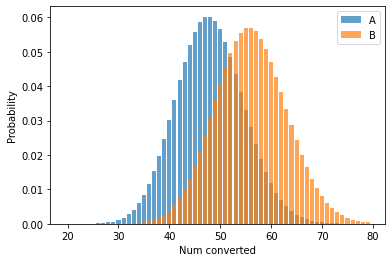

In [ ]:
# Determine the probability of having x number of click throughs
clicks = np.arange(20, 80)
prob_a = binom(num_a, rate_a).pmf(clicks)
prob_b = binom(num_b, rate_b).pmf(clicks)
# Make the bar plots.
plt.bar(clicks, prob_a, label="A", alpha=0.7)
plt.bar(clicks, prob_b, label="B", alpha=0.7)
plt.legend()
plt.xlabel("Num converted"); plt.ylabel("Probability");

So we can see here that b has an edge, but its certaintly possible if we pick two random points according to the histograms for A and B, that A might actually be higher than B!

###Choose the right primary metric
When performing a test, you usually have one metric in mind that is the primary — the winning variation will be determined by the success of each variation for this metric. This can include any user activity, such as clicking a specific button, adding items to the cart, completing a purchase, etc.

***If you were asked to set a metric for an e-commerce website like amazon what would you do?***

--------------

A marketer for an eCommerce site once asked:

“Why do you allow so many metrics to choose from? I only need one: Revenue.”

As with any business relying on revenue, it makes sense as an approach that everything contributing to this goal would be good, and everything negatively impacting it, bad. 

###Let’s get normal

Sure, we can work with binomial distributions in this case. And Poisson distributions in the “How long were you on the site” case. We could swap for every question… or we can invoke the Central Limit Theorem. As we’re interested in the average conversion, or average time spent on the site, this averaging of an underlying distribution means our final estimate will be well approximated by a normal distribution.

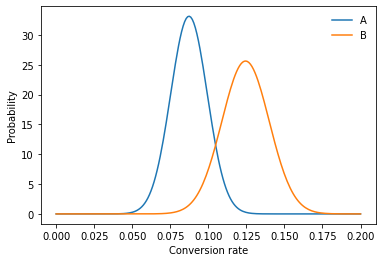

In [ ]:
std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)

click_rate = np.linspace(0, 0.2, 200)
prob_a = norm(rate_a, std_a).pdf(click_rate)
prob_b = norm(rate_b, std_b).pdf(click_rate)

# Make the bar plots.
plt.plot(click_rate, prob_a, label="A")
plt.plot(click_rate, prob_b, label="B")
plt.legend(frameon=False)
plt.xlabel("Conversion rate"); plt.ylabel("Probability");

This is also a better plot than the first one, because we’ve removed the confusing effect of site A and site B having a slightly different number of visitors had. So our question is still the same: What is the chance that a draw from B is higher than a draw from A. Is it significant?

To answer this, let us utilise the handy fact that the sum (or difference) of normally distributed random numbers is also a normal.[See here for proof](https://en.wikipedia.org/wiki/Sum_of_normally_distributed_random_variables#Independent_random_variables), but the math is as follows:


![formula](https://i.imgur.com/KpiLQ0T.png)

This is simple - take the difference in the means and sum the variance. We’ll do two things below: First, get the z-score, and second, plot the proper distribution.


zscore is 1.890, with p-value 0.029


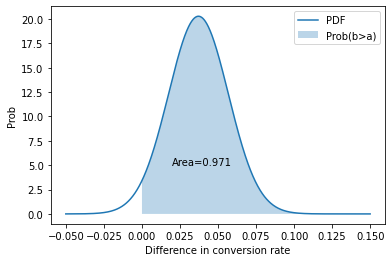

In [ ]:
z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
p = norm(rate_b - rate_a, np.sqrt(std_a**2 + std_b**2))

x = np.linspace(-0.05, 0.15, 1000)
y = p.pdf(x)
area_under_curve = p.sf(0)
plt.plot(x, y, label="PDF")
plt.fill_between(x, 0, y, where=x>0, label="Prob(b>a)", alpha=0.3)
plt.annotate(f"Area={area_under_curve:0.3f}", (0.02, 5))
plt.legend()
plt.xlabel("Difference in conversion rate"); plt.ylabel("Prob");

print(f"zscore is {z_score:0.3f}, with p-value {norm().sf(z_score):0.3f}")

Great! So, how to phrase this result? Using our frequentist approach so far, we would say that given the null hypothesis is true (that B is less then or equal to A), we would expect to get this result or a result more exterme only 2.9% of the time. As that is a significant result (typically p < 5%), we reject the null hypothesis, and state that we have evidence that B > A.

We should explicitly note here that this is a one-tailed test - the question we’ve asked is if B > A. An alterative is the two-tailed test, where we just want to discriminate that B is different to A. In that case, our p-value is actually 2×2.9=5.8

percent (as we have two tails, not one), and we would want more samples before rejecting the null hypothesis if we stick to the p-value of 0.05 threshold.

However, we’ve made a lot of plots for this to try and explain the concept. You can easily write a tiny function to simplify all of this. Whether you want the confidence or the p-value just means changing the final norm.cdf to norm.sf.

In [ ]:
def get_confidence_ab_test(click_a, num_a, click_b, num_b):
    rate_a = click_a / num_a
    rate_b = click_b / num_b
    std_a = np.sqrt(rate_a * (1 - rate_a) / num_a)
    std_b = np.sqrt(rate_b * (1 - rate_b) / num_b)
    z_score = (rate_b - rate_a) / np.sqrt(std_a**2 + std_b**2)
    return norm.cdf(z_score)

print(get_confidence_ab_test(click_a, num_a, click_b, num_b))

0.9705973498275782


###Hypothesis test outcomes


1.   If  H0  is true and we failed to reject  H0 , then we have correctly not rejected the null.
2.   If  H0  is true and we rejected  H0 , then we have made a Type I error;
3.   If  HA  is true and we rejected  H0 , then we have correctly rejected the null;
4.   If  HA  is true and we failed to reject  H0 , then we have made Type II error.
![errors](https://chemicalstatistician.files.wordpress.com/2014/05/pregnant.jpg)



###Can we check we’ve done the right thing?
So what if we’re not confident that we’ve done the math perfectly? Is there a way we can brute force a check? Turns out, there is, just not from the very beginning. We can start at our normal approximation and go from there.

In [ ]:
# Draw 10000 samples of possible rates for a and b
n = 10000
rates_a = norm(rate_a, std_a).rvs(n)
rates_b = norm(rate_b, std_b).rvs(n)
b_better = (rates_b > rates_a).sum() / n
print(f"B is better than A {b_better * 100:0.1f}% of the time")

B is better than A 97.2% of the time


Which, rephrased to the language of before, is that A > B only 2.8% of the time, which is statistically significant such that we can reject our hypothesis (that A <= B).

Often this is the way we would actually do more complicated analyses, when there isn’t an analytic solution. The power of modern computing opens many doors!

###Can we do this test even faster?

We’ve done some math ourselves, taking things down to a normal distribution and doing a basic difference of means test. But scipy has lots of stuff hidden inside it to make our lives easier. Here imagine we have the raw results of click through, 0 or 1, as our distribution, and we want to use an inbuild t-test.

##Welsch’s t-test

In [ ]:
a_dist = np.zeros(num_a)
a_dist[:click_a] = 1
b_dist = np.zeros(num_b)
b_dist[:click_b] = 1
zscore, prob = ttest_ind(a_dist, b_dist, equal_var=False)
print(f"Zscore is {zscore:0.2f}, p-value is {prob:0.3f} (two tailed), {prob/2:0.3f} (one tailed)")

Zscore is -1.89, p-value is 0.059 (two tailed), 0.030 (one tailed)


Note here that the p-value by default is using the two-tailed test. We can see these values are almost identical to the ones we computed ourselves… but they’re not exactly the same. Why is this? Well, the ttest_ind (with equal_var=False) is running Welch’s t-test. The t-test has degrees-of-freedom which will induce subtle differences with the normal approximation. Additionally, Welsch’s t-test is meant for continuous data, we have discrete 0 and 1 options.

In [ ]:
stat, p_value = mannwhitneyu(a_dist, b_dist, alternative="less")
print(f"Mann-Whitney U test for null hypothesis B <= A is {p_value:0.3f}")

Mann-Whitney U test for null hypothesis B <= A is 0.028


### What can make my A/B test results unreliable?



1.   You Called It Too Early
2.   You Set Up The Test Wrong
3.   You Didn’t Outline Your Goal
4.   You Chose A Bad Testing Period
5.   Your survey was too generic



### A/B testing can go wrong and it did in this case

"I want to take a tangent to describe some analysis I did on an A/B test looking at airtime usage (aka phone credit) in Malawi for a telecommunication company to illustrate the pitfalls here.

This A/B test examined the effect of a new product on airtime usage. During the A/B test, we asked people to recall how much money they had spent in the last month on airtime, and unbeknownst to them, we also had data from the telecommunications company on the actual amount spent by the same customers. When we compared the two metrics, we found there was very little correlation! Furthermore, when we looked at who was most likely to over-estimate their airtime spend, we found it was young, urban males.

Now consider — had we only had the self-reported data, we would have thought that young urban men were big spenders on airtime, drawn many conclusions from this, and found many “statistically significant” (in terms of P-values of < 0.05) relationships! We would have made many recommendations to the telecommunications company about the new product, and our results would have held up to thorough statistical interrogation. In short — there would have been very little way to know we were wrong, but we would have been wrong nevertheless!

The moral of this story is that the best statistics in the world will not save a trial from poor measurement. The other moral is that self-reported data is often terrible (beware survey-heavy NGOs!), as it is influenced by how people want to be perceived ( perhaps by the interviewer, by the community, or by their own embarrassment about “low” airtime spends)."